In [17]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import numpy as np
import math
import pdb
import itertools
import time
from classifier.linear_classifier import LinearSVM

Clear previously loaded data.


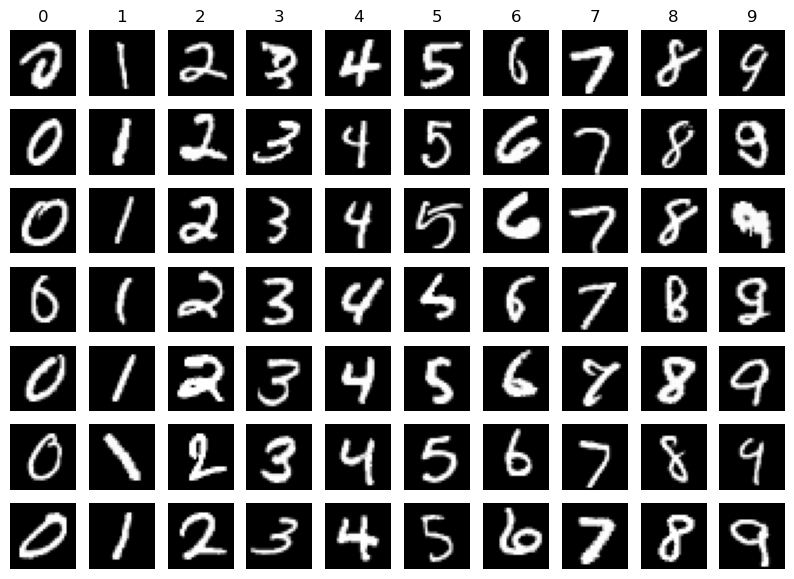

In [75]:
transform = transforms.Compose([transforms.ToTensor()])

train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test = datasets.MNIST(root='./data', train = False, download = True, transform=transform)

try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train = train.data.numpy(), train.targets.numpy()
X_test, y_test = test.data.numpy(), test.targets.numpy()

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 7


plt.figure(figsize=(10, 7))

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == int(cls))  
    idxs = np.random.choice(idxs, samples_per_class, replace=False) 
    
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)  
        plt.imshow(X_train[idx], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(cls)

plt.show()

In [57]:
num_training = 59000
num_validation = 1000
num_test = 1000
num_dev = 500

mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]


mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

# Gộp lại input img thành 1 vector 1 chiều.
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

print('Train data: ', X_train.shape)
print('Val data: ', X_val.shape)
print('test val: ', X_test.shape)
print('Dev data: ', X_dev.shape)

Train data:  (59000, 784)
Val data:  (1000, 784)
test val:  (1000, 784)
Dev data:  (500, 784)


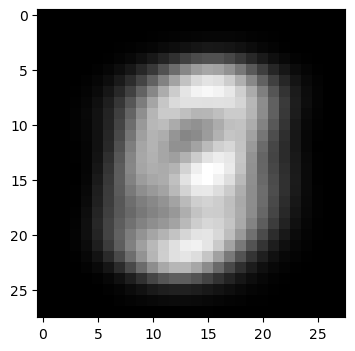

(59000, 785) (1000, 785) (1000, 785) (500, 785)


In [59]:
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)
X_dev = X_dev.astype(np.float32)

mean_image = np.mean(X_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((28,28)), cmap='gray')
plt.show()

X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val= np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

In [63]:
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 25017.669142
iteration 100 / 1500: loss 25002.491328
iteration 200 / 1500: loss 25001.753739
iteration 300 / 1500: loss 25001.322645
iteration 400 / 1500: loss 25001.128058
iteration 500 / 1500: loss 25001.160703
iteration 600 / 1500: loss 25001.176907
iteration 700 / 1500: loss 25001.150983
iteration 800 / 1500: loss 25001.241664
iteration 900 / 1500: loss 25001.207493
iteration 1000 / 1500: loss 25000.995020
iteration 1100 / 1500: loss 25001.218859
iteration 1200 / 1500: loss 25001.160195
iteration 1300 / 1500: loss 25001.161645
iteration 1400 / 1500: loss 25001.240772
That took 0.708639s


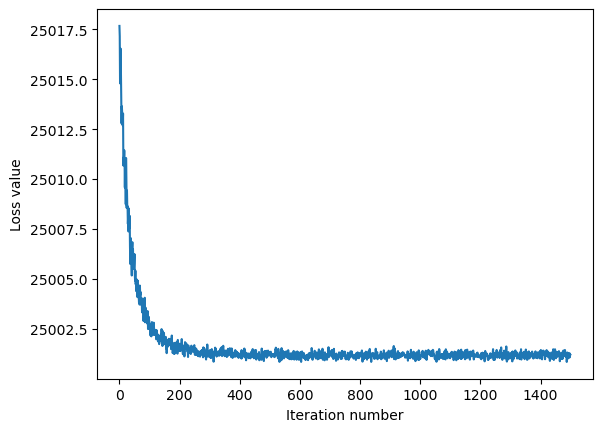

In [65]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [69]:
y_train_pred = svm.predict(X_train)
print('Train accu: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('Val accu: %f' % (np.mean(y_val == y_val_pred), ))

train accu: 0.869559
Val accu: 0.917000


In [71]:
results = {}
best_val = -1
best_svm = None


learning_rates = np.geomspace(2e-7, 3e-7, 5)
regularization_strengths = np.geomspace(5e3, 5e4, 5)

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    svm = LinearSVM()
    svm.train(X_train, y_train, lr, reg, num_iters=1000)
    
    y_train_pred, y_val_pred = svm.predict(X_train), svm.predict(X_val)
    results[(lr, reg)] = np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred)

    if results[(lr, reg)][1] > best_val:
        best_val = results[(lr, reg)][1]
        best_svm = svm
    
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('Learn rate %e reg %e train accu: %f val accu: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('Best cross-val accu: %f' % best_val)

Learn rate 2.000000e-07 reg 5.000000e+03 train accu: 0.886458 val accu: 0.921000
Learn rate 2.000000e-07 reg 8.891397e+03 train accu: 0.885254 val accu: 0.923000
Learn rate 2.000000e-07 reg 1.581139e+04 train accu: 0.875288 val accu: 0.919000
Learn rate 2.000000e-07 reg 2.811707e+04 train accu: 0.864203 val accu: 0.910000
Learn rate 2.000000e-07 reg 5.000000e+04 train accu: 0.854763 val accu: 0.911000
Learn rate 2.213364e-07 reg 5.000000e+03 train accu: 0.888102 val accu: 0.920000
Learn rate 2.213364e-07 reg 8.891397e+03 train accu: 0.885203 val accu: 0.926000
Learn rate 2.213364e-07 reg 1.581139e+04 train accu: 0.876424 val accu: 0.920000
Learn rate 2.213364e-07 reg 2.811707e+04 train accu: 0.864729 val accu: 0.918000
Learn rate 2.213364e-07 reg 5.000000e+04 train accu: 0.851797 val accu: 0.910000
Learn rate 2.449490e-07 reg 5.000000e+03 train accu: 0.888644 val accu: 0.922000
Learn rate 2.449490e-07 reg 8.891397e+03 train accu: 0.882695 val accu: 0.923000
Learn rate 2.449490e-07 reg 

In [73]:
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Final accu: %f' % test_accuracy)

Final accu: 0.887000
